In [ ]:
# 1
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2
# install library/package
!pip install Sastrawi #untuk menjalankan stemming
!pip install fasttext #untuk mentraining embedding fasttext
!pip install gensim #untuk mentraining embedding fasttext
!pip install iterative-stratification #untuk menggunakan multilabel stratified k-fold

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296187 sha256=a7072c855e51f7803709fe63f0d5f780ce4726e13c230b69b721c345dd3a991a
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
# 3
#import library/package
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import Sastrawi
import codecs
import numpy as np
import shutil
import fasttext
import keras
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from gensim.corpora import WikiCorpus
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from gensim.models import FastText
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
# plt.style.use('bmh')

In [ ]:
#check data
df = pd.read_csv("/content/drive/MyDrive/TA/data/Sirkuit_Mandalika_Final.csv")
df

,full_text,aspek,sentimen
0,Coba jalan-jalan di Mandalika sekitar sirkuit....,ekonomi,negatif
1,@detikcom pak sirkuit mandalika kapan di sindi...,ekonomi,negatif
2,@HeangKadrun @nepriadi74 @geloraco Ah bpk sdh ...,ekonomi,negatif
3,lawak bgt gue pikir pas denger isu tubatu ke m...,ekonomi,negatif
4,Selesaikan 30 Lap pada Hari Pertama di Mandali...,ekonomi,negatif
...,...,...,...
3417,Setelah balapan motogp di mandalika nama Indon...,politik,positif
3418,Kesan para pebalap #MotoGP kepada Presiden Jok...,politik,positif
3419,Presiden Jokowi optimistis #MotoGP mampu mempe...,politik,positif
3420,MotoGP berterima kasih atas sambutan hangat In...,politik,positif


**1. Cleaning Data**

In [ ]:
#melihat jumlah data
df.shape

(3422, 3)

In [ ]:
#fungsi untuk membersihkan data
def cleaning(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text) #membersihkan mention
  text = re.sub(r'#\w+', '', text) #membersihkan hastag
  text = re.sub(r'RT[\s]+', '', text) #membersihkan retweet
  text = re.sub(r'https?://\S+', '', text) #membersihkan url

  text = re.sub(r'[^A-Za-z0-9 ]', '', text) #membersihkan karakter selain A-Z, a-z, 0-9, spasi
  text = re.sub(r'\s+', ' ', text).strip() #membersihkan spasi yang berlebihan

  return text

df['full_text'] = df['full_text'].apply(cleaning)
df.head()

,full_text,aspek,sentimen
0,Coba jalanjalan di Mandalika sekitar sirkuit I...,ekonomi,negatif
1,pak sirkuit mandalika kapan di sindir pak raky...,ekonomi,negatif
2,Ah bpk sdh pikun x hasil di depan mata nampak ...,ekonomi,negatif
3,lawak bgt gue pikir pas denger isu tubatu ke m...,ekonomi,negatif
4,Selesaikan 30 Lap pada Hari Pertama di Mandali...,ekonomi,negatif


In [ ]:
#mengganti huruf menjadi huruf kecil
df['full_text'] = df['full_text'].str.lower()
df.head()

,full_text,aspek,sentimen
0,coba jalanjalan di mandalika sekitar sirkuit i...,ekonomi,negatif
1,pak sirkuit mandalika kapan di sindir pak raky...,ekonomi,negatif
2,ah bpk sdh pikun x hasil di depan mata nampak ...,ekonomi,negatif
3,lawak bgt gue pikir pas denger isu tubatu ke m...,ekonomi,negatif
4,selesaikan 30 lap pada hari pertama di mandali...,ekonomi,negatif


**2. Preprocessing**

In [ ]:
#normalisasi

norm = {" tsk ": " tidak "," tdk ": " tidak ", " sdh ": " sudah ", " yg ": " yang ",
        " blm ": " belum ", " gk ": " tidak ", " bgt ": " banget ", " tak ": " tidak ",
        " mmg ": " memang ", " dgn ": " dengan ", " utk ": " untuk ", " tp ": " tapi ",
        " spt ": " seperti ", "skrg ": " sekarang ", " ngk ": " tidak ", " jg ": " juga ",
        " kmrn ": " kemarin ", " wkt ": " waktu ", " trs ": " terus ", " lg ": " lagi ", " mrk ": " mereka ",
        " bpk ": " bapak ", " sdh ": " sudah ", " bkln ": " bakalan ", " pndptan ": " pendapatan ",
        " bgmn ": " bagaimana ", " gue ": " saya ", " gt ": " gitu ", " gw ": " saya ",
        " dah ": " sudah ", " x ": " kali ", " jls ": " jelas ", " msh ": " masih ",
        " utang ": " hutang ", " sgl ": " segala ", " gak ": " tidak ", " anjeng ": " anjing ",
        " better ": " lebih baik ", " mo ": " mau ", " geblek ": " goblok ", "kek": "kayak", "slh": "salah", "yak": "ya",
        "drpd": "daripada", "bekum": "belum", "paenonton": "penonton", "becua": "becus", "pertadingan": "pertandingan"}

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

df['full_text'] = df['full_text'].apply(lambda x: normalisasi(x))
df.head()

,full_text,aspek,sentimen
0,coba jalanjalan di mandalika sekitar sirkuit i...,ekonomi,negatif
1,pak sirkuit mandalika kapan di sindir pak raky...,ekonomi,negatif
2,ah bapak sudah pikun kali hasil di depan mata ...,ekonomi,negatif
3,lawak banget saya pikir pas denger isu tubatu ...,ekonomi,negatif
4,selesaikan 30 lap pada hari pertama di mandali...,ekonomi,negatif


In [ ]:
#stopwords #meghapus kata yang tidak memiliki arti

stop_words = StopWordRemoverFactory().get_stop_words()

new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopwords(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

df['full_text'] = df['full_text'].apply(lambda x: stopwords(x))
df.head()

,full_text,aspek,sentimen
0,coba jalanjalan mandalika sirkuit kan lombok b...,ekonomi,negatif
1,pak sirkuit mandalika kapan sindir pak rakyat ...,ekonomi,negatif
2,ah bapak pikun kali hasil depan mata nampak ti...,ekonomi,negatif
3,lawak banget pikir pas denger isu tubatu manda...,ekonomi,negatif
4,selesaikan 30 lap hari pertama mandalika mario...,ekonomi,negatif


In [ ]:
#tokenize

tokenized = df['full_text'].apply(lambda x: x.split())
tokenized.head()

,full_text
0,"[coba, jalanjalan, mandalika, sirkuit, kan, lo..."
1,"[pak, sirkuit, mandalika, kapan, sindir, pak, ..."
2,"[ah, bapak, pikun, kali, hasil, depan, mata, n..."
3,"[lawak, banget, pikir, pas, denger, isu, tubat..."
4,"[selesaikan, 30, lap, hari, pertama, mandalika..."


In [ ]:
#stemming

def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  return d_clean

tokenized = tokenized.apply(stemming )

In [ ]:
# simpan data stemming di drive
tokenized.to_csv("/content/drive/MyDrive/TA/data/preprocessing/data_stemming.csv", index=False)

In [ ]:
# gabung data yang sudah di preprocessing dengan data yang bersisi kolom aspek & sentimen
df1 = pd.read_csv("/content/drive/MyDrive/TA/data/preprocessing/data_stemming.csv", encoding='latin-1')
df2 = pd.read_csv("/content/drive/MyDrive/TA/data/aspek&sentimen.csv", encoding='latin-1')
joined_df = df1.join(df2, how='inner')
joined_df

,full_text,aspek,sentimen
0,coba jalanjalan mandalika sirkuit kan lombok b...,ekonomi,negatif
1,pak sirkuit mandalika kapan sindir pak rakyat ...,ekonomi,negatif
2,ah bapak pikun kali hasil depan mata nampak ti...,ekonomi,negatif
3,lawak banget pikir pas denger isu tubatu manda...,ekonomi,negatif
4,selesai 30 lap hari pertama mandalika mario ku...,ekonomi,negatif
...,...,...,...
3417,balap motogp mandalika nama indonesia makin ke...,politik,positif
3418,kesan balap presiden jokowi sangat senang seka...,politik,positif
3419,presiden jokowi optimistis mampu kuat branding...,politik,positif
3420,motogp terima kasih atas sambut hangat indones...,politik,positif


In [ ]:
# simpan data ke Gdrive
joined_df.to_csv("/content/drive/MyDrive/TA/data/data_ready.csv", index=False)

**3. Persiapan Klasifikasi**

In [ ]:
# 5
# tokenisasi dan padding
data = pd.read_csv("/content/drive/MyDrive/TA/data/data_ready.csv")
max_words = 10000
max_len = 100
embedding_dim = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['full_text'])
sequences = tokenizer.texts_to_sequences(data['full_text'])
X_pad = pad_sequences(sequences, maxlen=max_len)

In [ ]:
# 7
# Prepare label
y_aspek = pd.get_dummies(data['aspek'])
y_sentimen = pd.get_dummies(data['sentimen'])
y_multilabel = np.hstack([y_aspek.values, y_sentimen.values])  # Gabungkan label menjadi satu array agar dapat diproses pada multilabel stratified k-fold

In [ ]:
X_pad

array([[   0,    0,    0, ...,  554, 1905,  166],
       [   0,    0,    0, ...,   59, 1119,  263],
       [   0,    0,    0, ...,  803,  200,  119],
       ...,
       [   0,    0,    0, ...,   10,   32,    1],
       [   0,    0,    0, ...,  254,  700, 3372],
       [   0,    0,    0, ...,  205,  342,  235]], dtype=int32)

In [ ]:
X_pad.shape

(3422, 100)

In [ ]:
y_aspek

,ekonomi,politik
0,True,False
1,True,False
2,True,False
3,True,False
4,True,False
...,...,...
3417,False,True
3418,False,True
3419,False,True
3420,False,True


In [ ]:
y_sentimen

,negatif,netral,positif
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
3417,False,False,True
3418,False,False,True
3419,False,False,True
3420,False,False,True


In [ ]:
y_multilabel

array([[ True, False,  True, False, False],
       [ True, False,  True, False, False],
       [ True, False,  True, False, False],
       ...,
       [False,  True, False, False,  True],
       [False,  True, False, False,  True],
       [False,  True, False, False,  True]])

In [ ]:
# Multilabel Stratified K-Fold pada data training
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List untuk menyimpan hasil evaluasi setiap fold
fold_results = []

for fold, (train_idx, test_idx) in enumerate(mskf.split(X_pad, y_multilabel)):
    print(f"Fold {fold + 1}")

    # bagi data training dan test
    X_train, X_test = X_pad[train_idx], X_pad[test_idx] #x
    y_train, y_test = y_multilabel[train_idx], y_multilabel[test_idx] #y

    # buat data testing akhir
    X_validation, X_testing, y_validation, y_testing = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

    # Pisahkan y menjadi aspek dan sentimen
    y_train_aspek, y_train_sentimen = y_train[:, :y_aspek.shape[1]], y_train[:, y_aspek.shape[1]:]
    y_validation_aspek, y_validation_sentimen = y_validation[:, :y_aspek.shape[1]], y_validation[:, y_aspek.shape[1]:]
    y_testing_aspek, y_testing_sentimen = y_testing[:, :y_aspek.shape[1]], y_testing[:, y_aspek.shape[1]:]

    count_aspek_train = np.sum(y_train_aspek, axis=0)
    count_sentimen_train = np.sum(y_train_sentimen, axis=0)
    print("Count X train: ", X_train.shape[0])
    print("Count Aspect train: ", count_aspek_train)
    print("Count Sentimen train: ", count_sentimen_train)
    count_aspek_val = np.sum(y_validation_aspek, axis=0)
    count_sentimen_val = np.sum(y_validation_sentimen, axis=0)
    print("Count X validation: ", X_validation.shape[0])
    print("Count Aspect Validation: ", count_aspek_val)
    print("Count Sentimen Validation: ", count_sentimen_val)
    count_aspek_test = np.sum(y_testing_aspek, axis=0)
    count_sentimen_test = np.sum(y_testing_sentimen, axis=0)
    print("Count X test: ", X_testing.shape[0])
    print("Count Aspect Test: ", count_aspek_test)
    print("Count Sentimen Test: ", count_sentimen_test)
    print("")

Fold 1
Count X train:  2737
Count Aspect train:  [1638 1099]
Count Sentimen train:  [ 996 1215  526]
Count X validation:  342
Count Aspect Validation:  [205 137]
Count Sentimen Validation:  [125 151  66]
Count X test:  343
Count Aspect Test:  [205 138]
Count Sentimen Test:  [125 152  66]

Fold 2
Count X train:  2737
Count Aspect train:  [1638 1099]
Count Sentimen train:  [ 997 1214  526]
Count X validation:  342
Count Aspect Validation:  [205 137]
Count Sentimen Validation:  [124 152  66]
Count X test:  343
Count Aspect Test:  [205 138]
Count Sentimen Test:  [125 152  66]

Fold 3
Count X train:  2738
Count Aspect train:  [1639 1099]
Count Sentimen train:  [ 997 1214  527]
Count X validation:  342
Count Aspect Validation:  [204 138]
Count Sentimen Validation:  [124 153  65]
Count X test:  342
Count Aspect Test:  [205 137]
Count Sentimen Test:  [125 151  66]

Fold 4
Count X train:  2738
Count Aspect train:  [1638 1100]
Count Sentimen train:  [ 997 1214  527]
Count X validation:  342
Coun

**CNN**

###

In [ ]:
# Multilabel Stratified K-Fold pada data training
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List untuk menyimpan hasil evaluasi setiap fold
fold_results = []

for fold, (train_idx, test_idx) in enumerate(mskf.split(X_pad, y_multilabel)):
    print(f"Fold {fold + 1}")

    # bagi data training dan test
    X_train, X_test = X_pad[train_idx], X_pad[test_idx] #x
    y_train, y_test = y_multilabel[train_idx], y_multilabel[test_idx] #y

    # buat data testing akhir
    X_validation, X_testing, y_validation, y_testing = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

    # Pisahkan y menjadi aspek dan sentimen
    y_train_aspek, y_train_sentimen = y_train[:, :y_aspek.shape[1]], y_train[:, y_aspek.shape[1]:]
    y_validation_aspek, y_validation_sentimen = y_validation[:, :y_aspek.shape[1]], y_validation[:, y_aspek.shape[1]:]
    y_testing_aspek, y_testing_sentimen = y_testing[:, :y_aspek.shape[1]], y_testing[:, y_aspek.shape[1]:]

    # Definisikan model multitask
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(max_words, embedding_dim, input_length=max_len, trainable=False)(input_layer)
    conv1 = Conv1D(128, 5, activation='relu')(embedding_layer)
    pooling1 = MaxPooling1D(2)(conv1)
    dropout1 = Dropout(0.7)(pooling1)
    conv2 = Conv1D(256, 5, activation='relu')(dropout1)
    pooling2 = MaxPooling1D(2)(conv2)
    dropout2 = Dropout(0.7)(pooling2)
    flatten = Flatten()(dropout2)
    dense1 = Dense(64, activation='relu')(flatten)
    dropout3 = Dropout(0.7)(dense1)
    aspek_output = Dense(y_aspek.shape[1], activation='sigmoid', name='aspek_output')(dropout3)
    sentimen_output = Dense(y_sentimen.shape[1], activation='softmax', name='sentimen_output')(dropout3)

    model_multitask = Model(inputs=input_layer, outputs=[aspek_output, sentimen_output])
    model_multitask.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss={'aspek_output': 'binary_crossentropy', 'sentimen_output': 'categorical_crossentropy'},
        metrics={'aspek_output': 'accuracy', 'sentimen_output': 'accuracy'}
    )

    # Train model pada fold ini
    history = model_multitask.fit(
        X_train, {'aspek_output': y_train_aspek, 'sentimen_output': y_train_sentimen},
        validation_data=(X_validation, {'aspek_output': y_validation_aspek, 'sentimen_output': y_validation_sentimen}),
        epochs=30,
        batch_size=64
    )

    # testing
    testing_loss, testing_aspek_loss, testing_sentimen_loss, testing_aspek_acc, testing_sentimen_acc = model_multitask.evaluate(
        X_testing, {'aspek_output': y_testing_aspek, 'sentimen_output': y_testing_sentimen}, verbose=0
    )

    print(f"Fold {fold + 1} -> testing Aspect Acc: {testing_aspek_acc:.4f}, testing Sentiment Acc: {testing_sentimen_acc:.4f}, "
          f"testing Aspect Loss: {testing_aspek_loss:.4f}, testing Sentiment Loss: {testing_sentimen_loss:.4f}")

    # Simpan hasil validasi untuk fold ini
    fold_results.append({
        'testing_aspek_acc': testing_aspek_acc,
        'testing_sentimen_acc': testing_sentimen_acc,
        'testing_aspek_loss': testing_aspek_loss,
        'testing_sentimen_loss': testing_sentimen_loss,
        'history': history.history  # Simpan data history
    })

# Hitung rata-rata hasil evaluasi
mean_aspek_acc = np.mean([result['testing_aspek_acc'] for result in fold_results])
mean_sentimen_acc = np.mean([result['testing_sentimen_acc'] for result in fold_results])
mean_aspek_loss = np.mean([result['testing_aspek_loss'] for result in fold_results])
mean_sentimen_loss = np.mean([result['testing_sentimen_loss'] for result in fold_results])

print("\nRata-rata hasil testing multilabel stratified k-fold:")
print(f"Aspect Accuracy: {mean_aspek_acc:.4f}, Sentiment Accuracy: {mean_sentimen_acc:.4f}")
print(f"Aspect Loss: {mean_aspek_loss:.4f}, Sentiment Loss: {mean_sentimen_loss:.4f}")


Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - aspek_output_accuracy: 0.5942 - aspek_output_loss: 0.6828 - loss: 1.7518 - sentimen_output_accuracy: 0.4219 - sentimen_output_loss: 1.0689 - val_aspek_output_accuracy: 0.5994 - val_aspek_output_loss: 0.6828 - val_loss: 1.7489 - val_sentimen_output_accuracy: 0.4415 - val_sentimen_output_loss: 1.0696
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - aspek_output_accuracy: 0.5930 - aspek_output_loss: 0.6813 - loss: 1.7353 - sentimen_output_accuracy: 0.4137 - sentimen_output_loss: 1.0540 - val_aspek_output_accuracy: 0.5994 - val_aspek_output_loss: 0.6814 - val_loss: 1.7397 - val_sentimen_output_accuracy: 0.4415 - val_sentimen_output_loss: 1.0624
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - aspek_output_accuracy: 0.5962 - aspek_output_loss: 0.6753 - loss: 1.7290 - sentimen_output_accuracy: 0.4427 - sentimen_output_loss: 1.0537 - val_aspek_output_accuracy: 0.5994 - val_aspek_output_loss: 0.6771 - val_loss: 1.7194 - val_sent

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - aspek_output_accuracy: 0.4881 - aspek_output_loss: 0.6964 - loss: 1.7651 - sentimen_output_accuracy: 0.4223 - sentimen_output_loss: 1.0687 - val_aspek_output_accuracy: 0.5994 - val_aspek_output_loss: 0.6837 - val_loss: 1.7471 - val_sentimen_output_accuracy: 0.4444 - val_sentimen_output_loss: 1.0577
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - aspek_output_accuracy: 0.5797 - aspek_output_loss: 0.6854 - loss: 1.7409 - sentimen_output_accuracy: 0.4161 - sentimen_output_loss: 1.0555 - val_aspek_output_accuracy: 0.5994 - val_aspek_output_loss: 0.6799 - val_loss: 1.7348 - val_sentimen_output_accuracy: 0.4444 - val_sentimen_output_loss: 1.0486
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - aspek_output_accuracy: 0.6045 - aspek_output_loss: 0.6765 - loss: 1.7269 - sentimen_output_accuracy: 0.4231 - sentimen_output_loss: 1.0504 - val_aspek_output_accuracy: 0.6082 - val_aspek_output_loss: 0.6790 - val_loss: 1.7280 - val_sentimen_output_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - aspek_output_accuracy: 0.5634 - aspek_output_loss: 0.6878 - loss: 1.7604 - sentimen_output_accuracy: 0.4329 - sentimen_output_loss: 1.0726 - val_aspek_output_accuracy: 0.5965 - val_aspek_output_loss: 0.6820 - val_loss: 1.7510 - val_sentimen_output_accuracy: 0.4444 - val_sentimen_output_loss: 1.0653
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - aspek_output_accuracy: 0.6040 - aspek_output_loss: 0.6820 - loss: 1.7367 - sentimen_output_accuracy: 0.4275 - sentimen_output_loss: 1.0548 - val_aspek_output_accuracy: 0.5965 - val_aspek_output_loss: 0.6762 - val_loss: 1.7312 - val_sentimen_output_accuracy: 0.4444 - val_sentimen_output_loss: 1.0505
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - aspek_output_accuracy: 0.5843 - aspek_output_loss: 0.6773 - loss: 1.7278 - sentimen_output_accuracy: 0.4485 - sentimen_output_loss: 1.0505 - val_aspek_output_accuracy: 0.5965 - val_aspek_output_loss: 0.6750 - val_loss: 1.7180 - val_sentimen_output

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - aspek_output_accuracy: 0.5331 - aspek_output_loss: 0.6927 - loss: 1.7653 - sentimen_output_accuracy: 0.4253 - sentimen_output_loss: 1.0727 - val_aspek_output_accuracy: 0.5965 - val_aspek_output_loss: 0.6823 - val_loss: 1.7509 - val_sentimen_output_accuracy: 0.4620 - val_sentimen_output_loss: 1.0700
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - aspek_output_accuracy: 0.6039 - aspek_output_loss: 0.6740 - loss: 1.7410 - sentimen_output_accuracy: 0.3900 - sentimen_output_loss: 1.0669 - val_aspek_output_accuracy: 0.5965 - val_aspek_output_loss: 0.6798 - val_loss: 1.7310 - val_sentimen_output_accuracy: 0.4415 - val_sentimen_output_loss: 1.0531
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - aspek_output_accuracy: 0.5912 - aspek_output_loss: 0.6793 - loss: 1.7266 - sentimen_output_accuracy: 0.4146 - sentimen_output_loss: 1.0473 - val_aspek_output_accuracy: 0.5965 - val_aspek_output_loss: 0.6752 - val_loss: 1.7181 - val_sentimen_output_a

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - aspek_output_accuracy: 0.5688 - aspek_output_loss: 0.6874 - loss: 1.7592 - sentimen_output_accuracy: 0.4230 - sentimen_output_loss: 1.0718 - val_aspek_output_accuracy: 0.5994 - val_aspek_output_loss: 0.6780 - val_loss: 1.7360 - val_sentimen_output_accuracy: 0.4444 - val_sentimen_output_loss: 1.0590
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - aspek_output_accuracy: 0.6030 - aspek_output_loss: 0.6777 - loss: 1.7468 - sentimen_output_accuracy: 0.4102 - sentimen_output_loss: 1.0691 - val_aspek_output_accuracy: 0.5994 - val_aspek_output_loss: 0.6757 - val_loss: 1.7256 - val_sentimen_output_accuracy: 0.4444 - val_sentimen_output_loss: 1.0514
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - aspek_output_accuracy: 0.5958 - aspek_output_loss: 0.6791 - loss: 1.7285 - sentimen_output_accuracy: 0.4446 - sentimen_output_loss: 1.0494 - val_aspek_output_accuracy: 0.5994 - val_aspek_output_loss: 0.6745 - val_loss: 1.7290 - val_sentimen_output

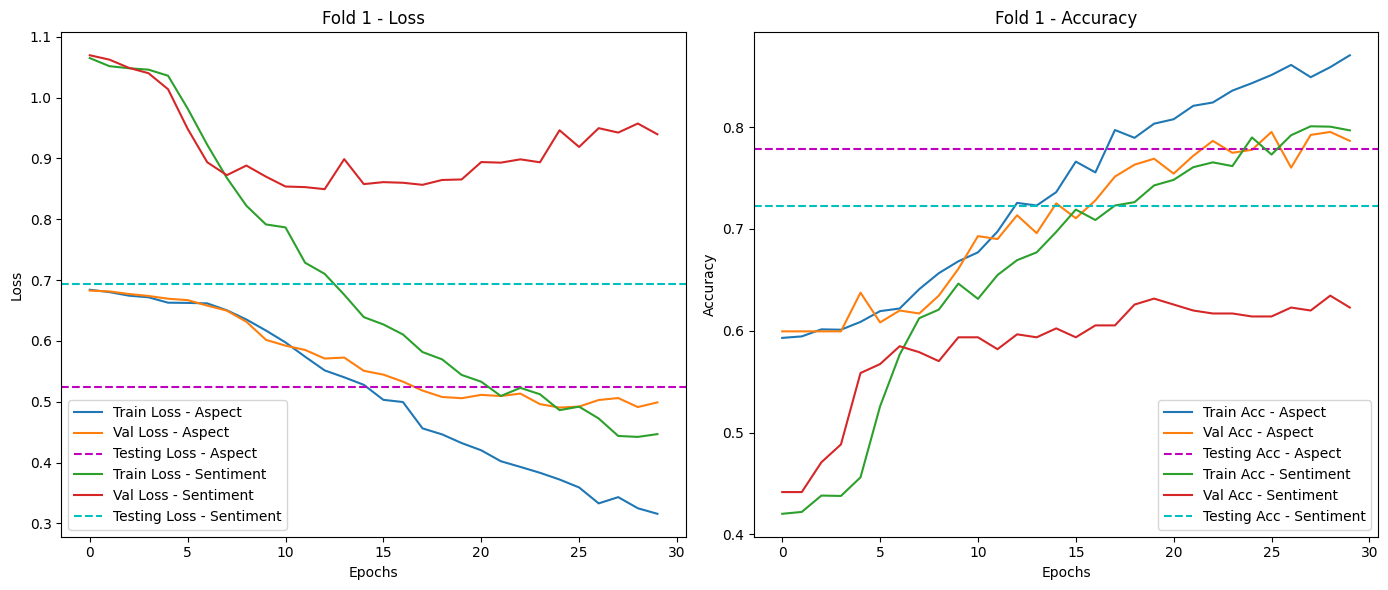

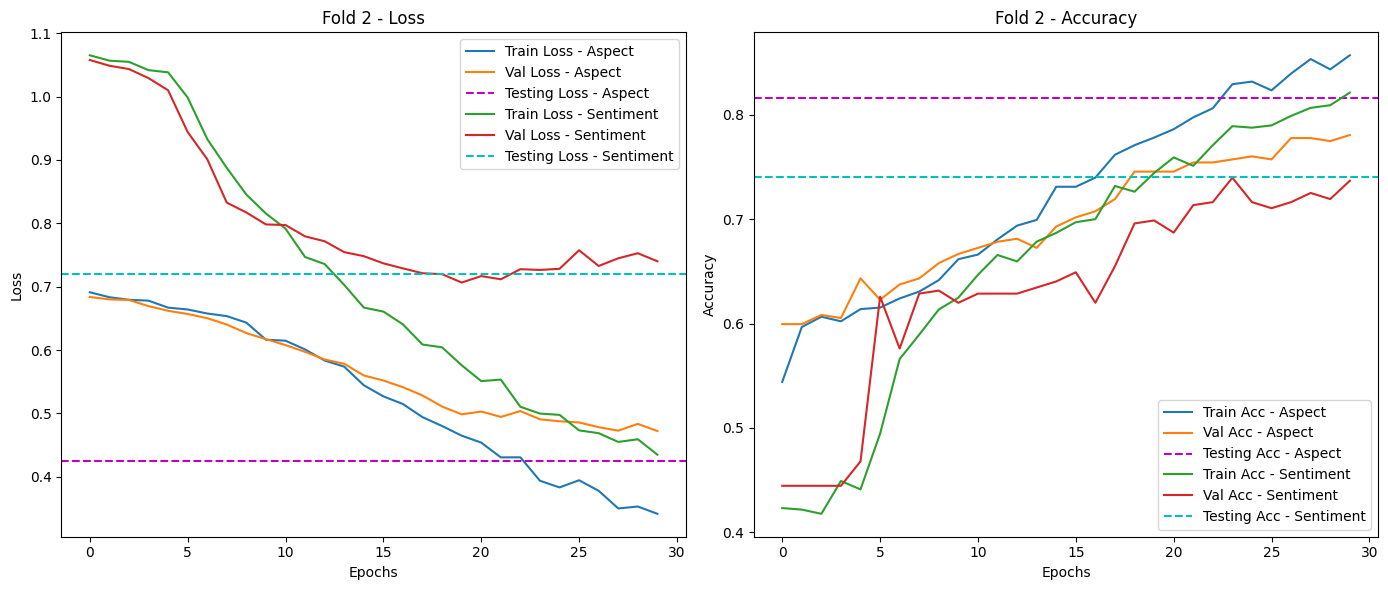

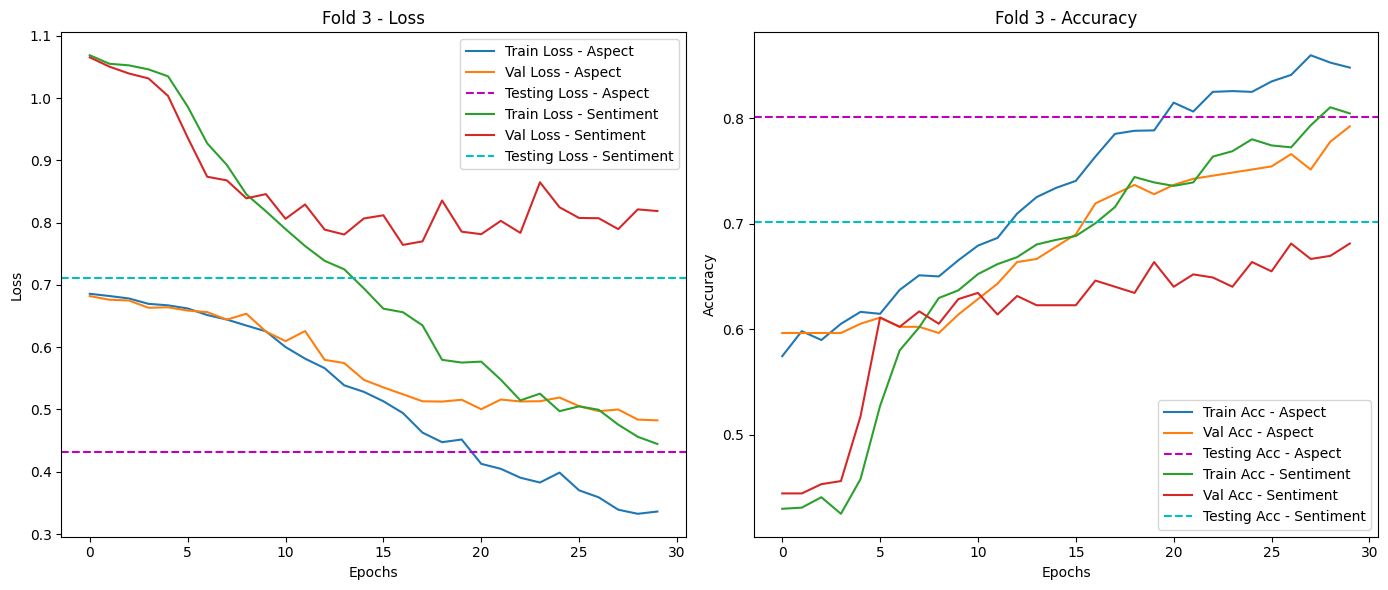

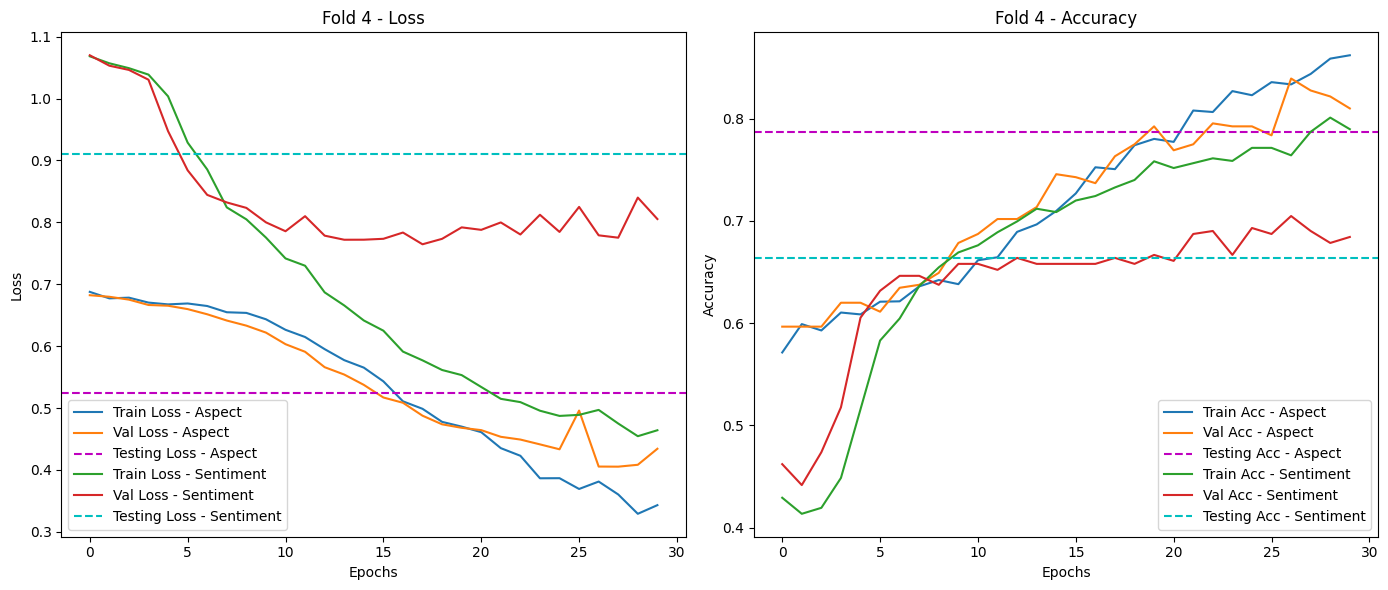

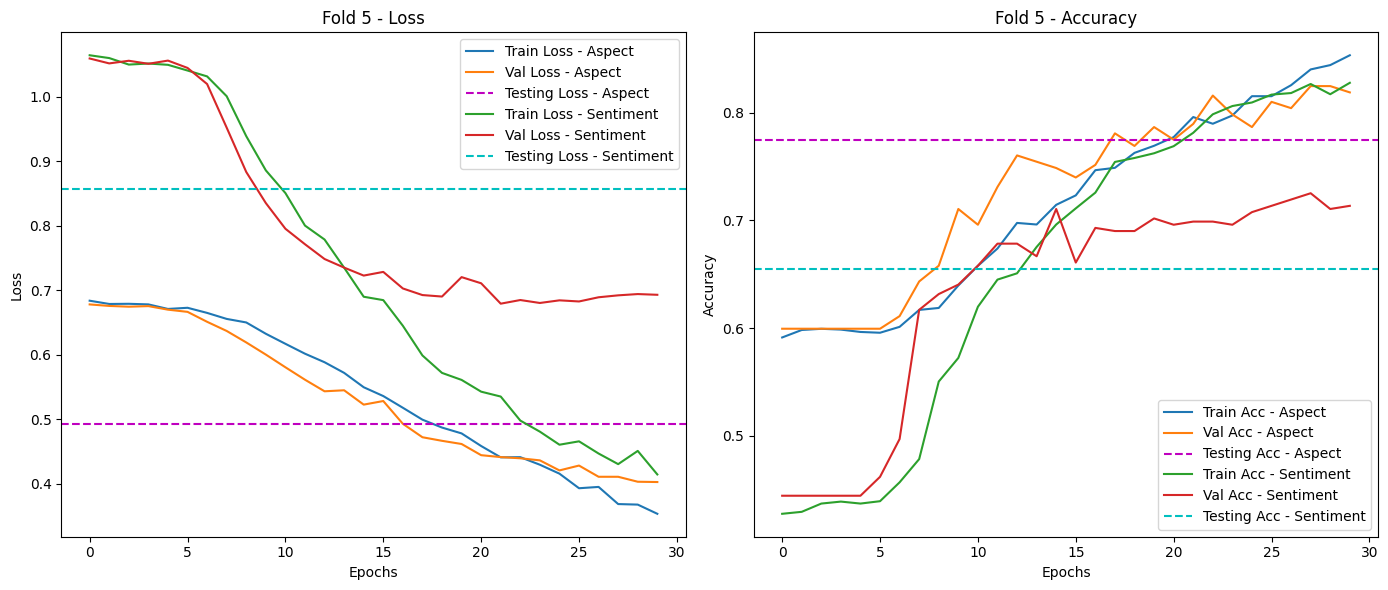

In [ ]:
# Loop untuk membuat grafik per fold
for fold, result in enumerate(fold_results):
    history = result['history']  # Ambil history dari fold ini
    testing_aspek_acc = result['testing_aspek_acc']
    testing_sentimen_acc = result['testing_sentimen_acc']
    testing_aspek_loss = result['testing_aspek_loss']
    testing_sentimen_loss = result['testing_sentimen_loss']

    # Plot loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['aspek_output_loss'], label='Train Loss - Aspect')
    plt.plot(history['val_aspek_output_loss'], label='Val Loss - Aspect')
    plt.axhline(y=testing_aspek_loss, color='m', linestyle='--', label='Testing Loss - Aspect')
    plt.plot(history['sentimen_output_loss'], label='Train Loss - Sentiment')
    plt.plot(history['val_sentimen_output_loss'], label='Val Loss - Sentiment')
    plt.axhline(y=testing_sentimen_loss, color='c', linestyle='--', label='Testing Loss - Sentiment')
    plt.title(f'Fold {fold + 1} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['aspek_output_accuracy'], label='Train Acc - Aspect')
    plt.plot(history['val_aspek_output_accuracy'], label='Val Acc - Aspect')
    plt.axhline(y=testing_aspek_acc, color='m', linestyle='--', label='Testing Acc - Aspect')
    plt.plot(history['sentimen_output_accuracy'], label='Train Acc - Sentiment')
    plt.plot(history['val_sentimen_output_accuracy'], label='Val Acc - Sentiment')
    plt.axhline(y=testing_sentimen_acc, color='c', linestyle='--', label='Testing Acc - Sentiment')
    plt.title(f'Fold {fold + 1} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Prediksi untuk semua data testing
pred_aspek, pred_sentimen = model_multitask.predict(X_testing)

# Konversi prediksi menjadi indeks label
pred_aspek_indices = np.argmax(pred_aspek, axis=1)  # Aspek
pred_sentimen_indices = np.argmax(pred_sentimen, axis=1)  # Sentimen

# Konversi label asli menjadi indeks
true_aspek_indices = np.argmax(y_testing_aspek, axis=1)
true_sentimen_indices = np.argmax(y_testing_sentimen, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


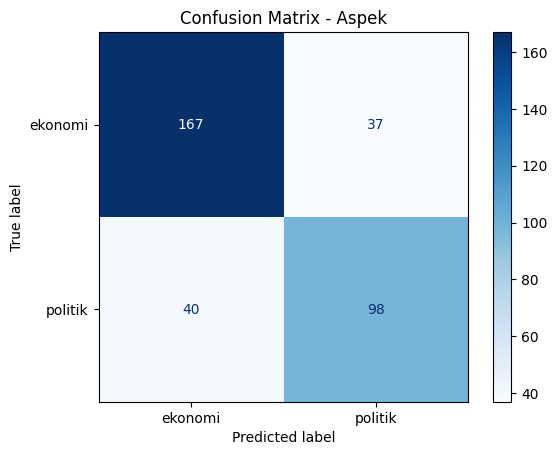

In [ ]:

# Buat confusion matrix untuk aspek
aspek_cm = confusion_matrix(true_aspek_indices, pred_aspek_indices)

# Tampilkan confusion matrix untuk aspek
aspek_labels = ['ekonomi', 'politik']  # Sesuaikan dengan label aspek Anda
disp_aspek = ConfusionMatrixDisplay(confusion_matrix=aspek_cm, display_labels=aspek_labels)
disp_aspek.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Aspek")
plt.show()


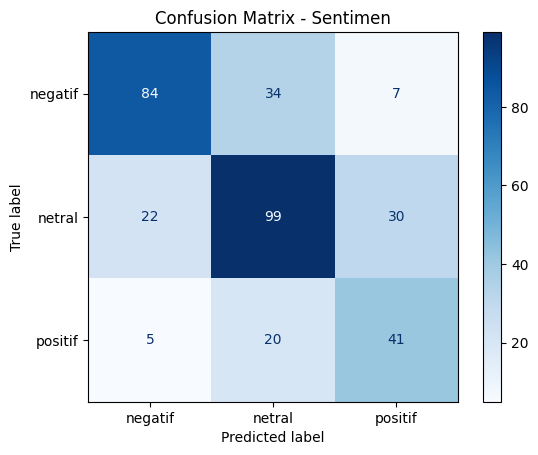

In [ ]:
# Buat confusion matrix untuk sentimen
sentimen_cm = confusion_matrix(true_sentimen_indices, pred_sentimen_indices)

# Tampilkan confusion matrix untuk sentimen
sentimen_labels = ['negatif', 'netral', 'positif']  # Sesuaikan dengan label sentimen Anda
disp_sentimen = ConfusionMatrixDisplay(confusion_matrix=sentimen_cm, display_labels=sentimen_labels)
disp_sentimen.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Sentimen")
plt.show()


In [ ]:
# Buat classification report untuk aspek
aspek_labels = ['ekonomi', 'politik']  # Sesuaikan dengan label aspek Anda
aspek_report = classification_report(true_aspek_indices, pred_aspek_indices, target_names=aspek_labels)
print("Classification Report - Aspek")
print(aspek_report)


Classification Report - Aspek
              precision    recall  f1-score   support

     ekonomi       0.81      0.82      0.81       204
     politik       0.73      0.71      0.72       138

    accuracy                           0.77       342
   macro avg       0.77      0.76      0.77       342
weighted avg       0.77      0.77      0.77       342



In [ ]:
# Buat classification report untuk sentimen
sentimen_labels = ['negatif', 'netral', 'positif']  # Sesuaikan dengan label sentimen Anda
sentimen_report = classification_report(true_sentimen_indices, pred_sentimen_indices, target_names=sentimen_labels)
print("Classification Report - Sentimen")
print(sentimen_report)


Classification Report - Sentimen
              precision    recall  f1-score   support

     negatif       0.76      0.67      0.71       125
      netral       0.65      0.66      0.65       151
     positif       0.53      0.62      0.57        66

    accuracy                           0.65       342
   macro avg       0.64      0.65      0.64       342
weighted avg       0.66      0.65      0.66       342

